# **START**

In [116]:
# importing packages and tools to be used

# datframe and array lib
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# features engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Data preprocessing
from sklearn.model_selection import train_test_split

# Model Selection and Training
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from keras.layers import Dropout

# Model Evaluation
from sklearn.metrics import classification_report

***Dataset Preparation***
*  ***Features*** - Pregnancies, Glucose, Blood Pressure, Skin thickness, Insulin, BMI, Diabetes Pedigree Function, Age
*   ***Labels*** - Outcome (0, 1)


In [118]:
# Load the dataset
df = pd.read_csv('diabetes.csv')
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Dataset Exploration/Visualization
(EDA)

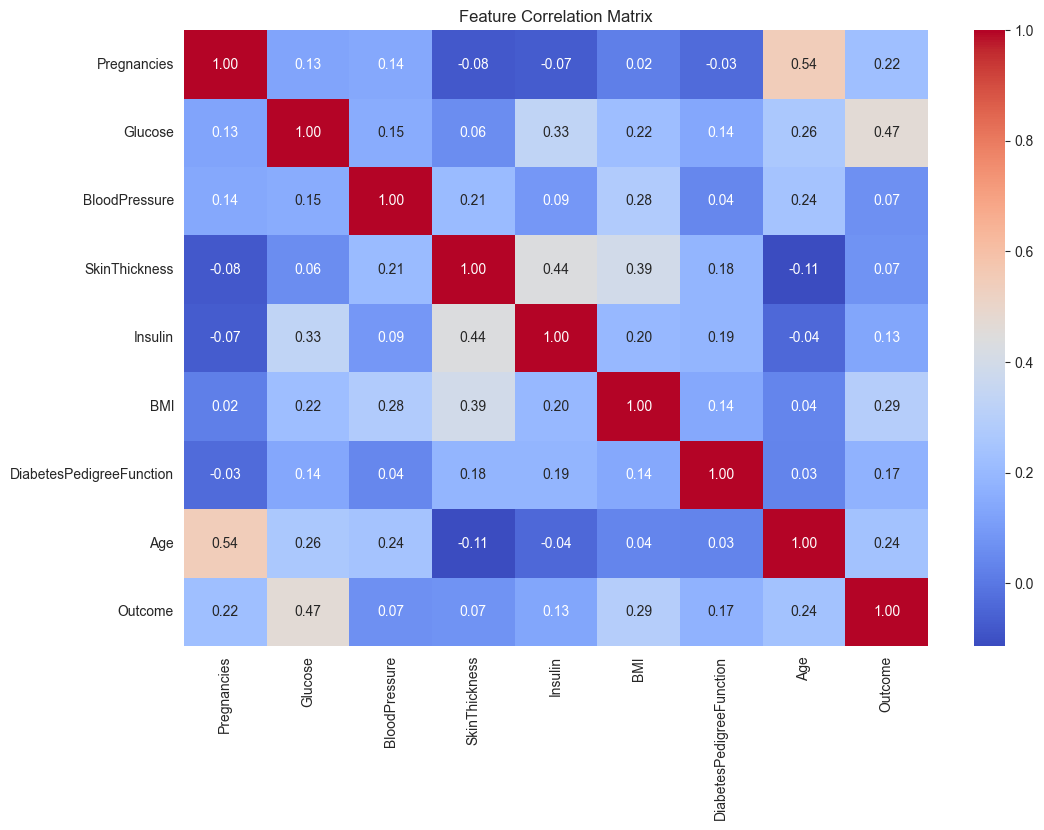

In [120]:
# Calculate and visualize correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

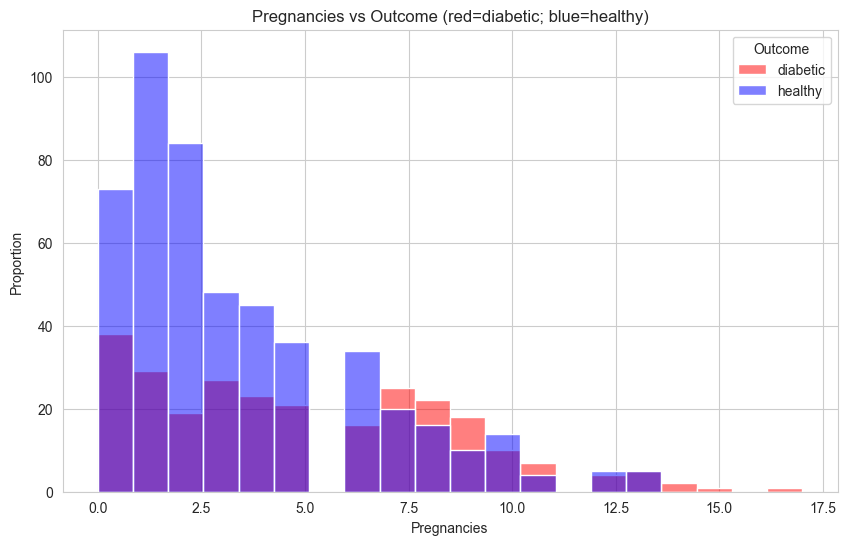

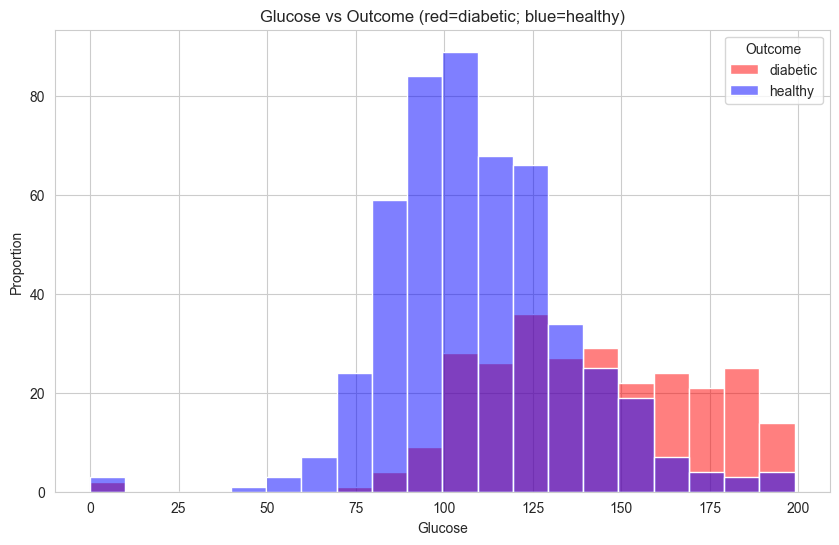

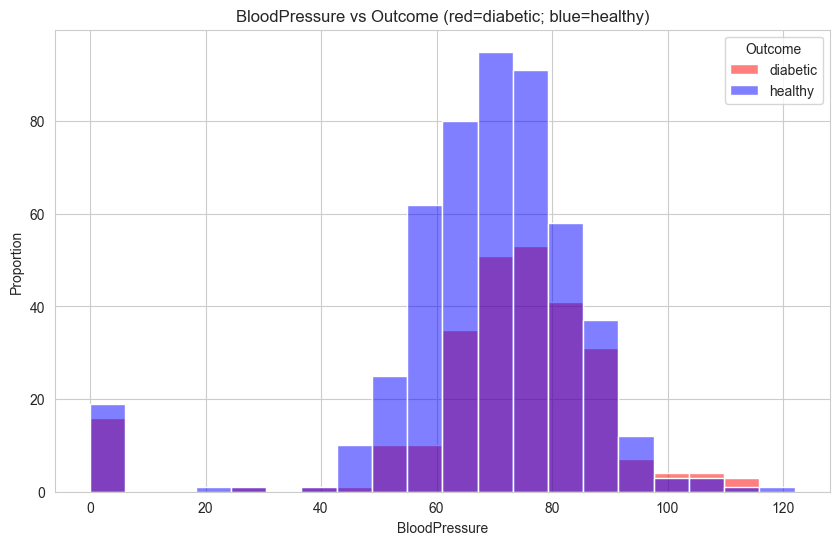

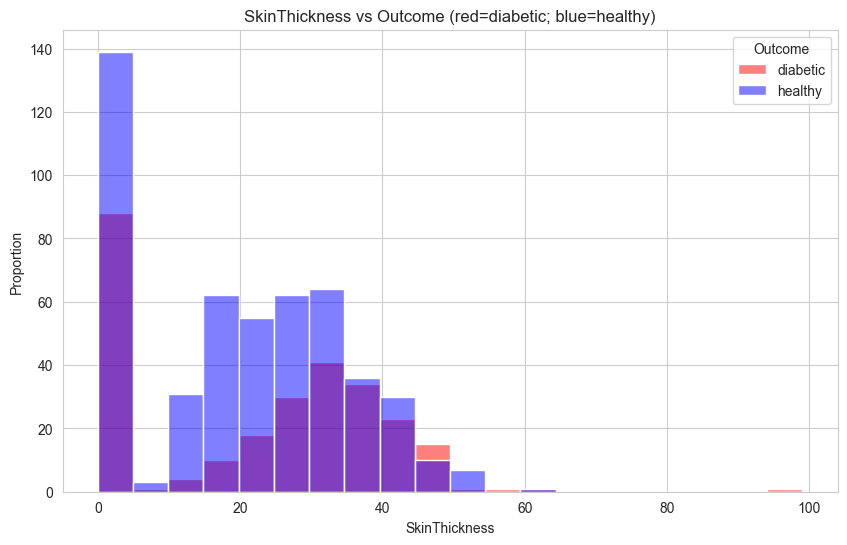

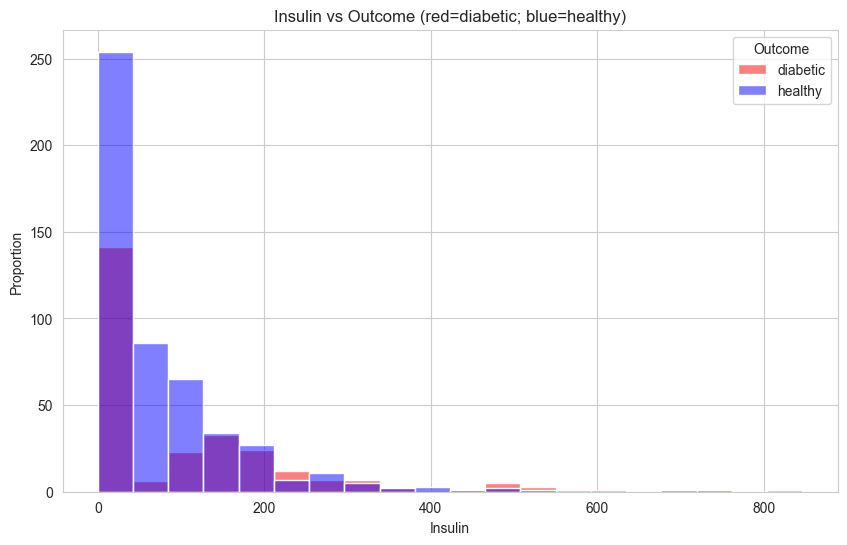

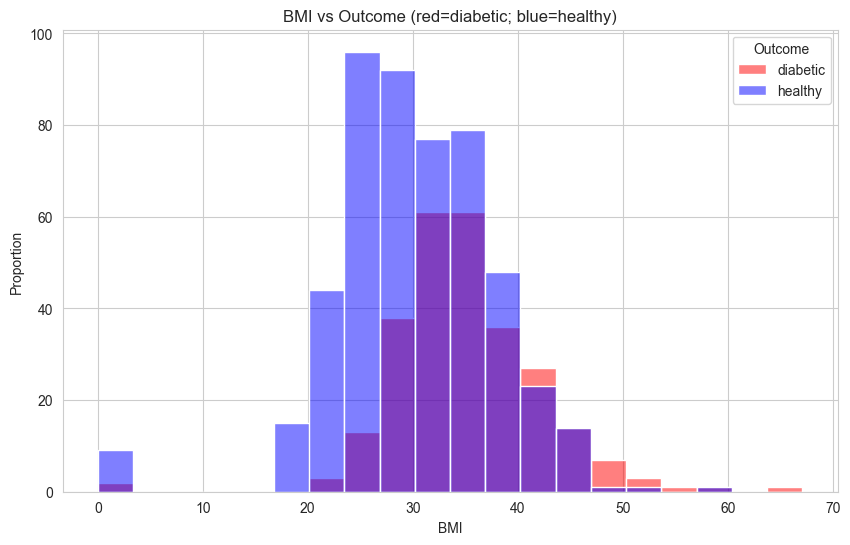

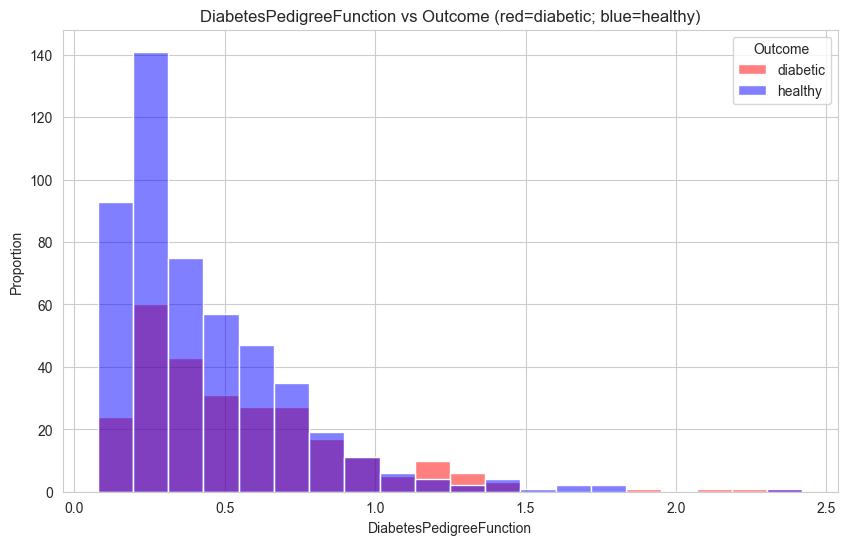

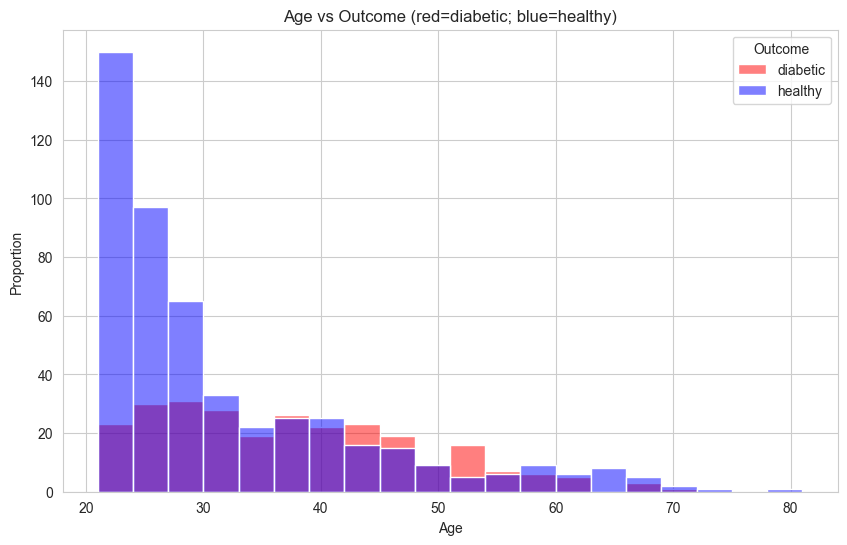

In [121]:
# lets visualize the feature against the label, especially the insulin and skinthickness
# to determine if there is correlation between a particular outcome and the nulled insulin and skintype
# Loop through each feature except the label (Outcome)
for feature in df.columns[:-1]:
    def plotHistogram(values, label, feature, title):
        sns.set_style("whitegrid")

        # Define a custom palette for the outcomes
        custom_palette = {0: "blue", 1: "red"}

        # Using sns.histplot
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=values,
            x=feature,
            hue=label,
            kde=False,
            palette=custom_palette,
            bins=20,
            alpha=0.5
        )
        plt.title(title)
        plt.xlabel(feature)
        plt.ylabel('Proportion')
        plt.legend(labels=["diabetic", "healthy"], title=label)
        plt.show()

    # Call the function
    plotHistogram(
        df,
        df.columns[-1],
        feature,
        f"{feature} vs {df.columns[-1]} (red=diabetic; blue=healthy)"
    )


So i can generalize that the absence of
insulin doesnt necesarry correlate to diabetic thus our model wouldnt be biased

---

Later we will closly observe this plot to understand the relationship between outcomes and the features to develop a simple recommendation algorithm

# Data Preprocessing
Working with missing values


---

since for pregnancies a value of 0 could be a woman with no pregnancies or a man..we will not be handling null for that

In [124]:
df[df.columns[1:6]] = df[df.columns[1:6]].replace(0, np.nan)

In [125]:
check_shape = df.drop(['Outcome'], axis=1)
print(f'\n The shape is --> {check_shape.shape}')


 The shape is --> (768, 8)


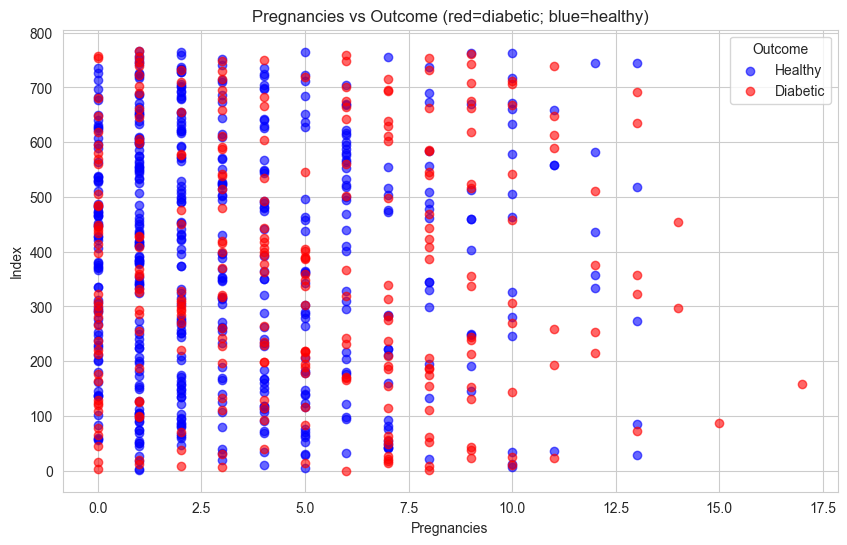

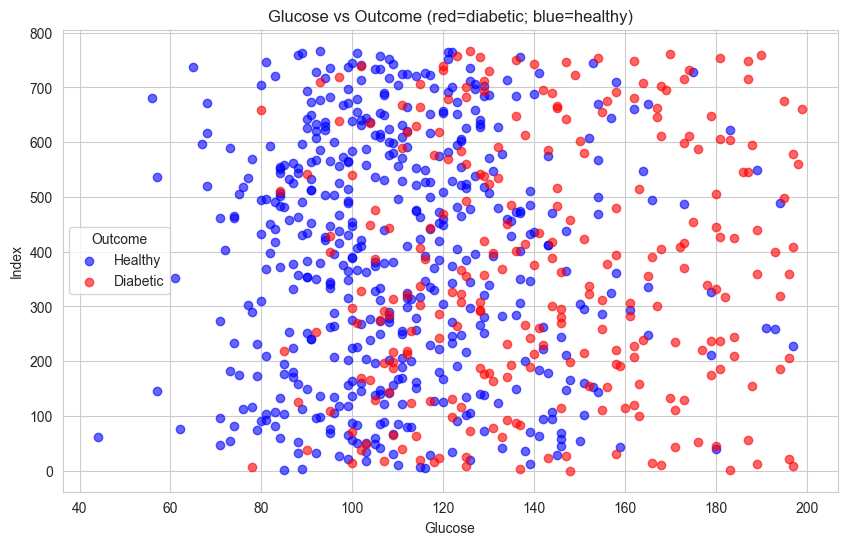

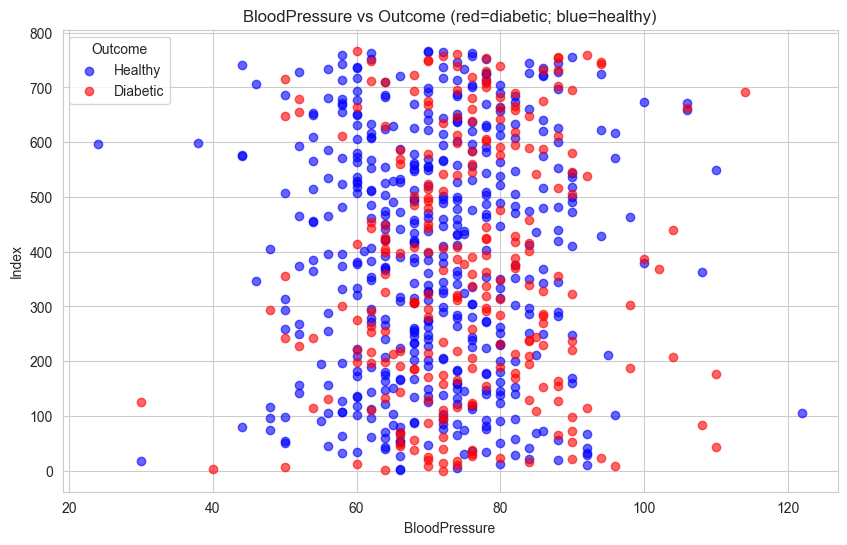

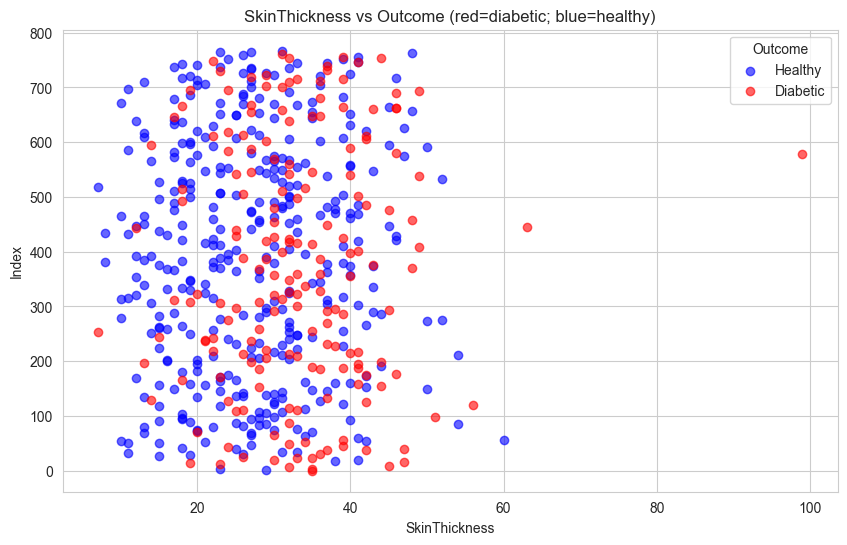

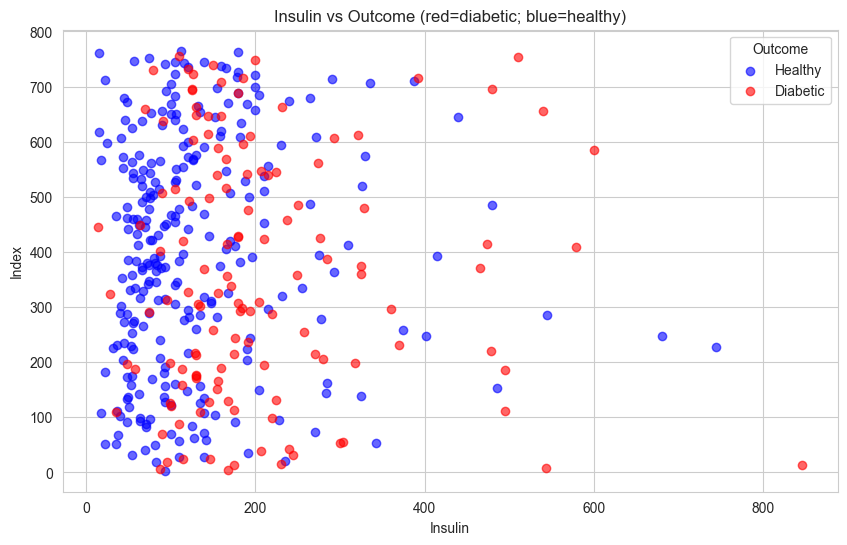

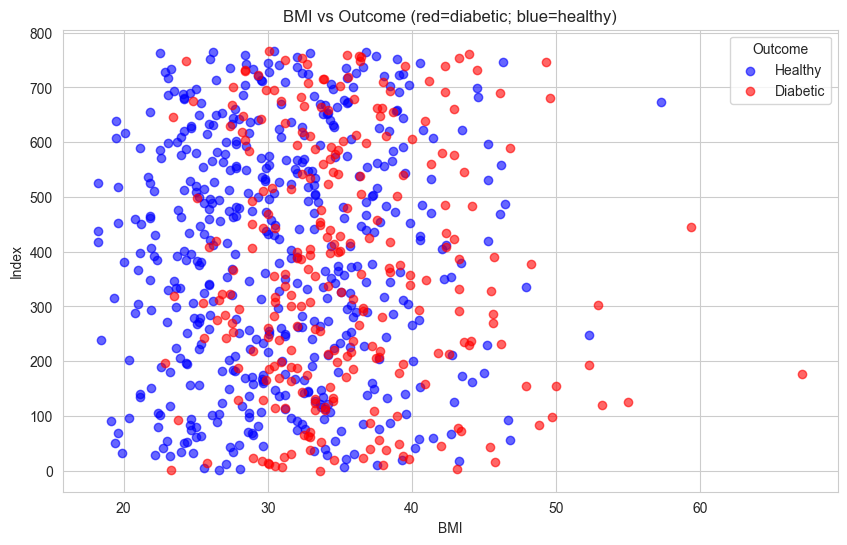

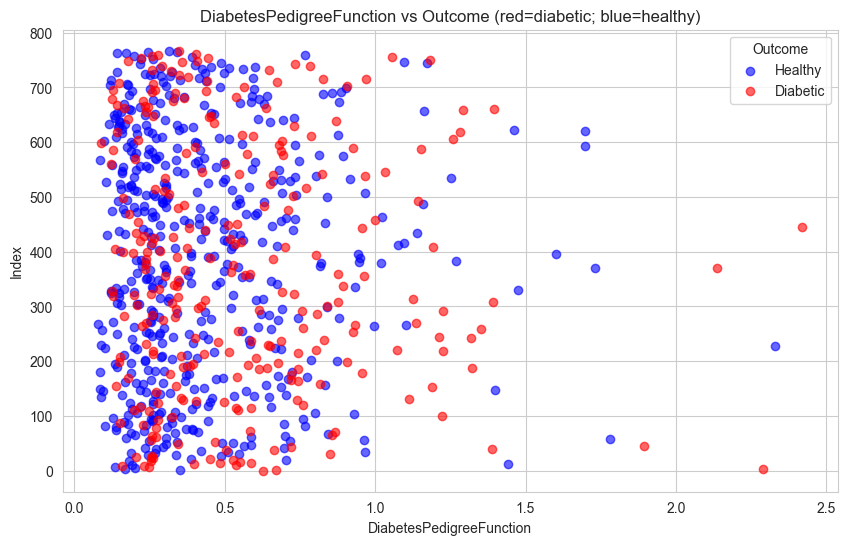

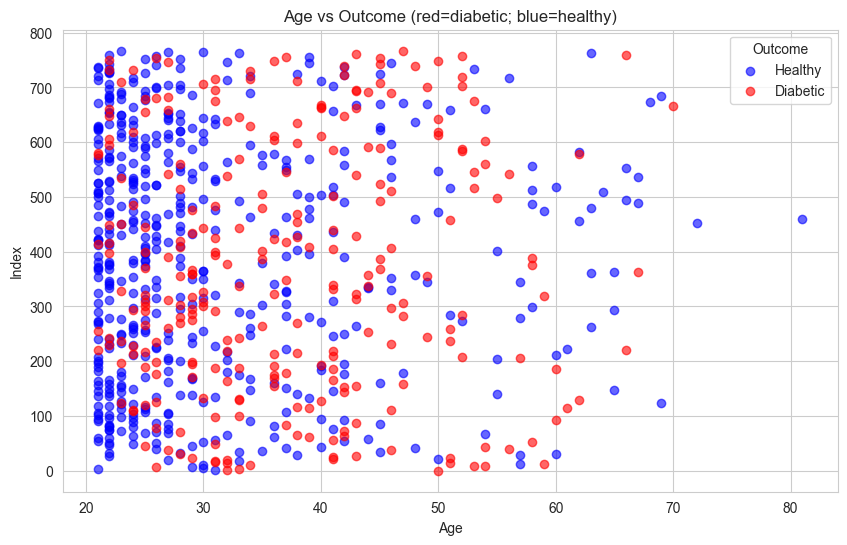

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the feature against the label using a scatter plot
for feature in df.columns[:-1]:
    def plotScatterPlot(values, label, feature, title):
        sns.set_style("whitegrid")

        # Define a custom palette for the outcomes
        custom_palette = {0: "blue", 1: "red"}

        # Create the scatter plot
        plt.figure(figsize=(10, 6))

        # Separate data based on the outcome
        for outcome, color in custom_palette.items():
            subset = values[values[label] == outcome]
            plt.scatter(subset[feature], subset.index, label=f"{'Diabetic' if outcome == 1 else 'Healthy'}", color=color, alpha=0.6)

        plt.title(title)
        plt.xlabel(feature)
        plt.ylabel('Index')
        plt.legend(title=label)
        plt.show()

    # Call the function
    plotScatterPlot(
        df,
        df.columns[-1],
        feature,
        f"{feature} vs {df.columns[-1]} (red=diabetic; blue=healthy)"
    )


In [127]:
print("Nulls \t\t\t   % of nulls \n")
print(df.isnull().sum()/768*100)

Nulls 			   % of nulls 

Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64


**plot to check what imputation to use**


FEATURE ENGINEERING/SELECTION


---

At this point i am going to split the datset to training and testing. After this i will apply the median imputer because of the outlier and skewed nature to fill up the null value..

---

I will now use the imputer to fit(learn) and transform the xtrain..then apply this value to the xtest to prevent data leakage, overfitting or re-learning

---

Also this imputation is not applied before splitting so our model would'nt learn bad data..we'll be test on our real-based datset and also prevent overly optimistc metrics

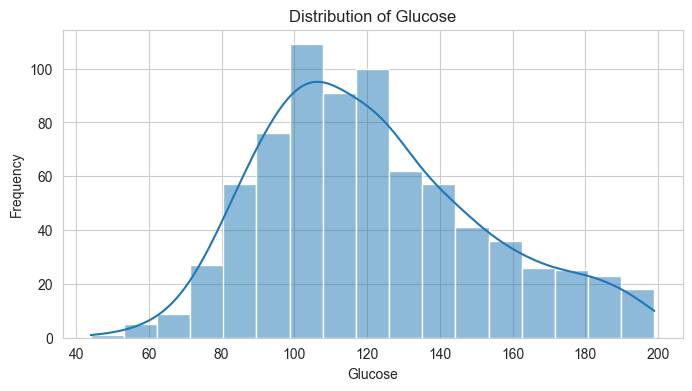

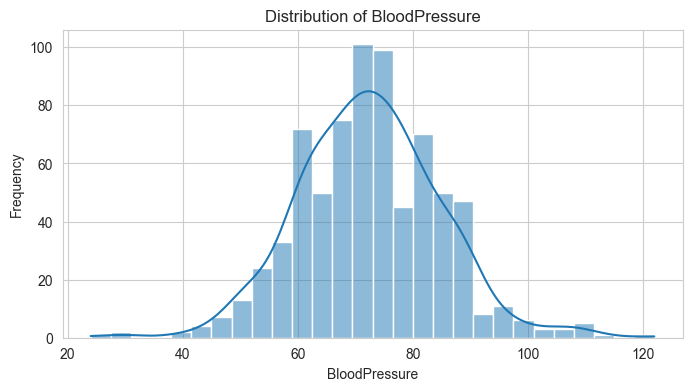

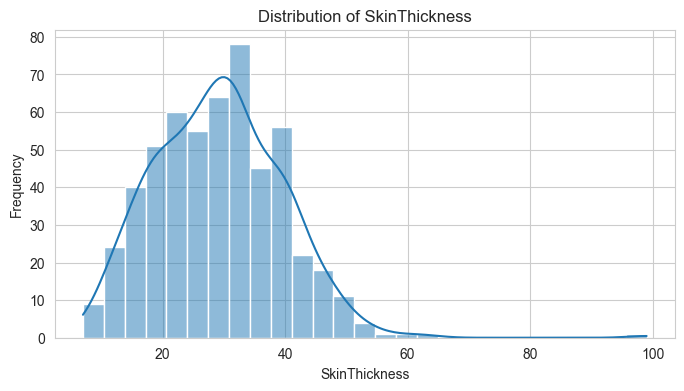

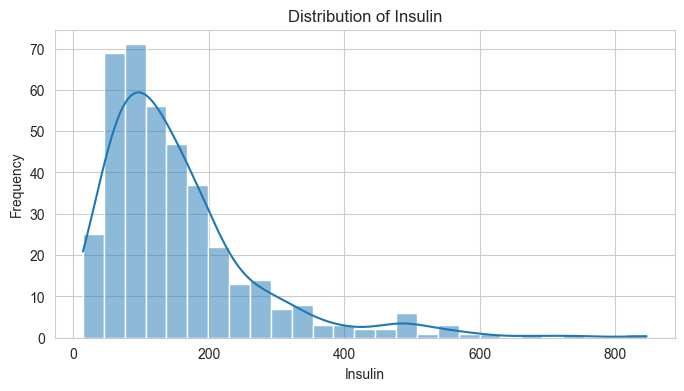

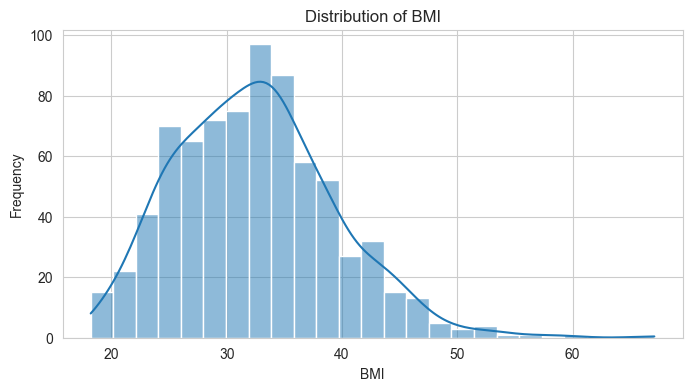

In [130]:
# Iterate over the specified columns
for col in df.columns[1:6]:
    plt.figure(figsize=(8, 4))  # Set the figure size
    sns.histplot(df[col], kde=True)  # Plot histogram with KDE
    plt.title(f'Distribution of {col}')  # Add a title
    plt.xlabel(col)  # Label the x-axis
    plt.ylabel('Frequency')  # Label the y-axis
    plt.show()  # Display the plot

After the plot, i am going to use median strategy for handlig missing values  because of the outliers in most features

In [132]:
#-----> i used this to test for the features to drop <------
# X = df[df.columns[:-1]]  # All columns except the last one
# y = df[df.columns[-1]]   # The last column
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# imputer = SimpleImputer(missing_values=np.nan,strategy='median')
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)


In [133]:
# another aspect of the feature engineering is the selection of the most
# relevant features to be used
X = df.drop(['SkinThickness', 'BloodPressure', 'Outcome'], axis=1)  # All columns except the last one
y = df[df.columns[-1]]   # The last column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [134]:
# confirming the shape of the features
print(X.shape)
print(X.columns)

(768, 6)
Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age'],
      dtype='object')


In [135]:
# Converting back to DataFrame to use to confirm the correlation between each features and the labels too
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Adding the target column
train_data = pd.concat([X_train_imputed, y_train.reset_index(drop=True)], axis=1)


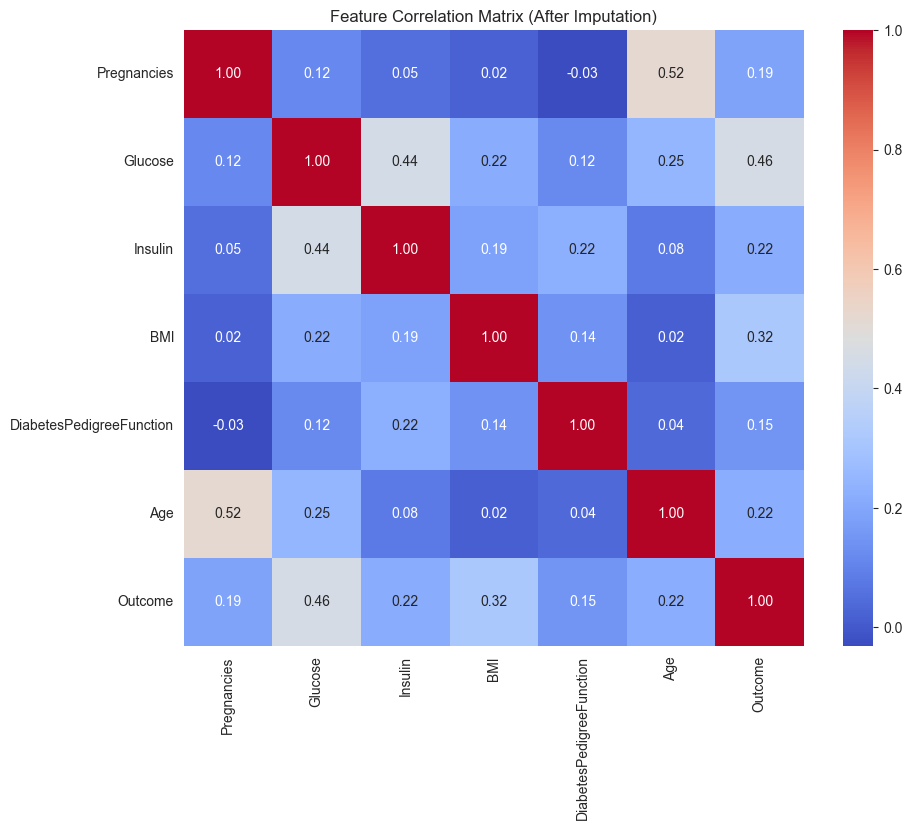

In [136]:
# Generating the heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix (After Imputation)")
plt.show()

In [137]:
# lets confirm there isnt null
x_train_check = pd.DataFrame(X_train_imputed)
x_test_check = pd.DataFrame(X_test_imputed)

print(f"Confirm X_train_imputed \n{x_train_check.isnull().sum()}")
print(f"\nConfirm X_test_imputed \n{x_test_check.isnull().sum()}")

Confirm X_train_imputed 
Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Confirm X_test_imputed 
0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64


In [138]:
# Scale the features (most models typically work better with scaled features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

C:\Users\HP\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# MODELS

In [140]:
# Models to test with hyperparameters
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=1, max_depth=5, min_samples_leaf=5),
    "SVM": SVC(random_state=1,class_weight='balanced'),
    "Logistic Regression": LogisticRegression(random_state=1,class_weight='balanced'),
    "Random Forest Classifier": RandomForestClassifier(random_state=1, min_samples_split=10, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=1),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Train for Medicine prediction
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"{model_name} Model Performance:")
    print(classification_report(y_test, y_pred))

Training Decision Tree...
Decision Tree Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       146
           1       0.75      0.55      0.64        85

    accuracy                           0.77       231
   macro avg       0.76      0.72      0.73       231
weighted avg       0.76      0.77      0.76       231

Training SVM...
SVM Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       146
           1       0.74      0.84      0.78        85

    accuracy                           0.83       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231

Training Logistic Regression...
Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       146
           1       0.70      0.81      0.75        85

    accuracy 

In [141]:
# # Build a more complex model with dropout
# def create_improved_nn_model():
#     model = Sequential()
#     model.add(Dense(units=128, activation='relu', input_dim=X_train_scaled.shape[1]))  # Increased units in the first layer
#     model.add(Dropout(0.3))  # Dropout for regularization
#     model.add(Dense(units=64, activation='relu'))  # Second hidden layer with more units
#     model.add(Dropout(0.3))  # Dropout for regularization
#     model.add(Dense(units=32, activation='relu'))  # Third hidden layer
#     model.add(Dense(units=1, activation='sigmoid'))  # Output layer

#     # Compile the model with a tuned learning rate
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [142]:
# # Train the improved model
# improved_nn_model = create_improved_nn_model()
# improved_nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)  # Increased epochs


In [143]:
# # Make predictions
# y_pred_improved_nn = (improved_nn_model.predict(X_test_scaled) > 0.5).astype("int32")


In [144]:
# # Evaluate performance
# print("Improved Neural Network Model Performance:")
# print(classification_report(y_test, y_pred_improved_nn))

From the models it is clear that it is SVM that  is the best with an accuracy of 83% let's define our model now

# Algorithm for Personalized prediction

In [147]:
model = SVC(random_state=1,class_weight='balanced', probability=True)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"{model} Model Performance:")
print(classification_report(y_test, y_pred))

SVC(class_weight='balanced', probability=True, random_state=1) Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       146
           1       0.74      0.84      0.78        85

    accuracy                           0.83       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231



before we go on, let's do some overview statistics

In [149]:
# Assuming your dataframe is named df
# Step 1: Filter the data based on glucose and DPF conditions
filtered_data = df[(df['Glucose'] >= 100) &
                   (df['DiabetesPedigreeFunction'] >= 0) & (df['DiabetesPedigreeFunction'] <= 1.0)]

# Step 2: Group by Outcome and describe the data
grouped_data = filtered_data.groupby('Outcome').size()  # Shows how many individuals fall under each outcome category

# Display the grouped data
print(grouped_data)


Outcome
0    305
1    225
dtype: int64


In [150]:
X.columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age'],
      dtype='object')

In [151]:
# def generate_recommendations(patient_data_scaled):
#     # Inverse transform the scaled data to its original scale
#     patient_data_original = scaler.inverse_transform(patient_data_scaled)

#     # Extract the features from the unscaled data for interpretation
#     glucose = patient_data_original[0][1]
#     insulin = patient_data_original[0][2]
#     bmi = patient_data_original[0][3]
#     age = patient_data_original[0][5]

#     # Map predictions to actual recommendations
#     recommendation_mapping = {
#         0: 'You are not diabetic. 😊',
#         1: 'You are diabetic. 🩺',
#         2: 'You are still at risk: Your glucose levels are elevated or there is a family history of diabetes. It is important to monitor your glucose and blood pressure. Lifestyle changes like a healthier diet and regular physical activity are highly recommended.',
#         3: 'You’re doing well: Keep up your healthy habits! Regular check-ups are important to ensure you maintain good health.',
#         4: 'Your glucose levels are high. Medication may be necessary, along with frequent monitoring. In addition, managing your diet and staying physically active are essential to control your condition.',
#         5: 'Your glucose levels are under moderate control, but ongoing monitoring and a balanced diet are still crucial. Consider incorporating more physical activity and regularly consulting with your healthcare provider.',
#         6: 'Though you have diabetes, your family history and other factors (e.g., age, BMI) suggest a higher risk of complications. It is essential to maintain regular check-ups and follow a strict diet and exercise plan.',
#         7: 'You are overweight but not diabetic. It is important to maintain a healthy diet and engage in regular physical activity to reduce health risks.',
#         8: 'You are diabetic and overweight. Managing your weight through a balanced diet and exercise is crucial to avoid complications.',
#     }

#     # Get the prediction
#     prediction = model.predict(patient_data_scaled)

#     # Initialize default recommendations
#     diabetes_status = recommendation_mapping[1]  # Default to diabetic
#     recommendation = recommendation_mapping[6]  # Default to high-risk

#     # Conditions for non-diabetic
#     if prediction == 0:
#         if glucose > 100:  # Elevated glucose
#             recommendation = recommendation_mapping[2]
#         elif bmi > 30:  # Overweight condition for non-diabetic
#             recommendation = recommendation_mapping[7]
#         else:
#             recommendation = recommendation_mapping[3]
#         diabetes_status = recommendation_mapping[0]

#     # Conditions for diabetic
#     else:
#         # High glucose condition
#         if glucose > 150:
#             recommendation = recommendation_mapping[4]
#         # Moderate glucose condition
#         elif 100 < glucose <= 150:
#             recommendation = recommendation_mapping[5]
#         # Overweight condition for diabetic
#         elif bmi > 30:
#             recommendation = recommendation_mapping[8]
#         # Default to high risk if other factors are significant
#         elif insulin > 200 or age > 50:
#             recommendation = recommendation_mapping[6]

#     return f"Diabetes Status: {diabetes_status}\nRecommendation: {recommendation}"

# # Example usage
# patient_data_example = pd.DataFrame({
#     'Pregnancies': [4],
#     'Glucose': [140],  # High glucose
#     'Insulin': [250],  # Elevated insulin
#     'BMI': [40],  # Elevated BMI
#     'DiabetesPedigreeFunction': [0.9],  # Moderate risk due to family history
#     'Age': [55]
# })

# patient_data_scaled = scaler.transform(patient_data_example)
# recommendation = generate_recommendations(patient_data_scaled)
# print(recommendation)


In [152]:
def generate_recommendations(patient_data_scaled):
    try:
        # Ensure input is a valid NumPy array or DataFrame
        if not isinstance(patient_data_scaled, (np.ndarray, pd.DataFrame)):
            raise ValueError("Input data must be a NumPy array or DataFrame.")

        # Inverse transform the scaled data to its original scale
        try:
            patient_data_original = scaler.inverse_transform(patient_data_scaled)
        except Exception as e:
            raise ValueError(f"Error in inverse transformation: {e}")

        # Extract features from the unscaled data for interpretation
        try:
            glucose = patient_data_original[0][1]
            insulin = patient_data_original[0][2]
            bmi = patient_data_original[0][3]
            age = patient_data_original[0][5]
        except IndexError as e:
            raise ValueError(f"Input data has missing or incomplete features: {e}")

        # Map predictions to actual recommendations
        recommendation_mapping = {
            0: 'You are not diabetic. 😊',
            1: 'You are diabetic. 🩺',
            2: 'You are still at risk: Your glucose levels are elevated or there is a family history of diabetes. It is important to monitor your glucose and blood pressure. Lifestyle changes like a healthier diet and regular physical activity are highly recommended.',
            3: 'You’re doing well: Keep up your healthy habits! Regular check-ups are important to ensure you maintain good health.',
            4: 'Your glucose levels are high. Medication may be necessary, along with frequent monitoring. In addition, managing your diet and staying physically active are essential to control your condition.',
            5: 'Your glucose levels are under moderate control, but ongoing monitoring and a balanced diet are still crucial. Consider incorporating more physical activity and regularly consulting with your healthcare provider.',
            6: 'Though you have diabetes, your family history and other factors (e.g., age, BMI) suggest a higher risk of complications. It is essential to maintain regular check-ups and follow a strict diet and exercise plan.',
            7: 'You are overweight but not diabetic. It is important to maintain a healthy diet and engage in regular physical activity to reduce health risks.',
            8: 'You are diabetic and overweight. Managing your weight through a balanced diet and exercise is crucial to avoid complications.',
        }

        # Get the prediction
        try:
            prediction = model.predict(patient_data_scaled)
        except Exception as e:
            raise ValueError(f"Error during prediction: {e}")

        # Initialize default recommendations
        diabetes_status = recommendation_mapping[1]  # Default to diabetic
        recommendation = recommendation_mapping[6]  # Default to high-risk

        # Conditions for non-diabetic
        if prediction == 0:
            if glucose > 100:  # Elevated glucose
                recommendation = recommendation_mapping[2]
            elif bmi > 30:  # Overweight condition for non-diabetic
                recommendation = recommendation_mapping[7]
            else:
                recommendation = recommendation_mapping[3]
            diabetes_status = recommendation_mapping[0]

        # Conditions for diabetic
        else:
            if glucose > 150:  # High glucose condition
                if bmi > 30:  # Overweight condition for diabetic
                  recommendation = recommendation_mapping[8]
                else:
                  recommendation = recommendation_mapping[4]
            elif 100 < glucose <= 150:  # Moderate glucose condition
                recommendation = recommendation_mapping[5]
            elif bmi > 30:  # Overweight condition for diabetic
                recommendation = recommendation_mapping[8]
            elif insulin > 200 or age > 50:  # Default to high risk
                recommendation = recommendation_mapping[6]

        return f"Diabetes Status: {diabetes_status}\nRecommendation: {recommendation}"

    except Exception as e:
        return f"An error occurred: {e}"


# Example usage
try:
    patient_data = pd.DataFrame({
    'Pregnancies': [7],
    'Glucose': [99],  # Borderline glucose
    'Insulin': [34],  # Slightly elevated insulin
    'BMI': [19.12],  # Slightly overweight
    'DiabetesPedigreeFunction': [2.11],  # High risk
    'Age': [68]  # Middle-aged
})

    patient_data_scaled = scaler.transform(patient_data)
    recommendation = generate_recommendations(patient_data_scaled)
    print(recommendation)

except Exception as e:
    print(f"Error in patient data processing: {e}")


Diabetes Status: You are not diabetic. 😊
Recommendation: You’re doing well: Keep up your healthy habits! Regular check-ups are important to ensure you maintain good health.


In [153]:
from joblib import dump
import json

# Save model and preprocessing objects
dump(model, '../diabetesApp/main/ml_models/diabetes_model.joblib')
dump(scaler, '../diabetesApp/main/ml_models/diabetes_scaler.joblib')
dump(imputer, '../diabetesApp/main/ml_models/diabetes_imputer.joblib')

# Save feature names
feature_names = list(X_train.columns)
with open('../diabetesApp/main/ml_models/feature_names.json', 'w') as f:
    json.dump(feature_names, f)